<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32604, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 32604 (delta 81), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32604/32604), 1.68 GiB | 31.10 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (32428/32428), done.


## Import

In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_ai46ad9
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_ai46ad9
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=162411 sha256=3dd59b210f538f88532f3ad37668f0274ea6e4331fe0904cad27b16899ff524b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fut3cbuv/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [4]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD


from pathlib import Path

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
test_df = pd.read_csv('DeepLearning20211/data/test.csv')

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

# Drop images with duplicated p-hash value 
train_df = train_df.drop_duplicates(subset=['image_phash']).reset_index(drop=True)

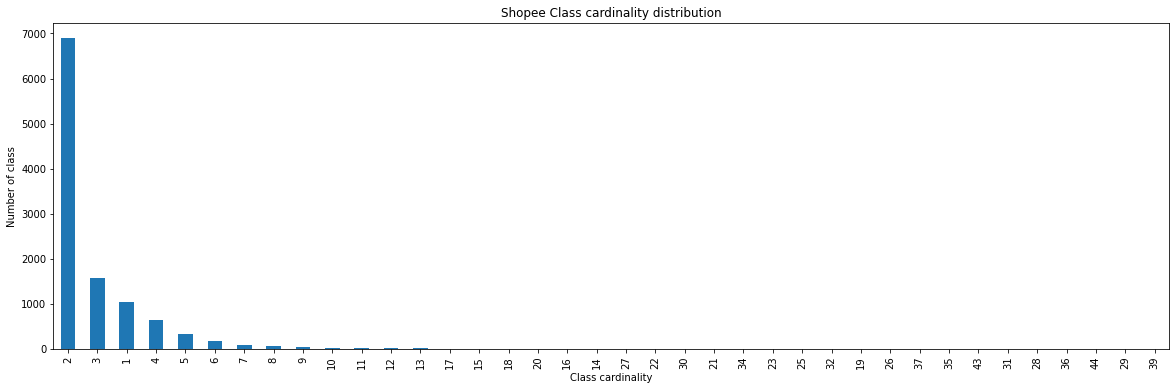

In [6]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

## Prepare dataset

In [7]:
#@title Take one instance in each class as anchor

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

In [8]:
#@title Create validation set
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.reset_index(drop=True)

In [ ]:
num_triplets = 200

In [ ]:
def create_dataset(mode):
    assert mode == 'training' or mode == 'validation', "argument mode should be 'training' or 'validation'" 
    df = train_df if mode == 'training' else val_df

    # container to store image path
    anchor_container = []
    positive_container = []
    negative_container = []

    # for each anchor image, create num_triplets triplets
    for anchor_label in anchor_df.index:
        anchor = anchor_df['image'][anchor_label]

        positive_df = df[df['label_group'] == anchor_label]
        if len(positive_df) > 1:
            positive_df = positive_df[positive_df['image'] != anchor]

        negative_df = df.groupby('label_group').nth(0)
        negative_df['label_group'] = negative_df.index
        negative_df = negative_df.reset_index(drop=True)
        negative_df = negative_df[negative_df['label_group'] != anchor_label]
        for _ in range(num_triplets if mode == 'training' else 3):
            anchor_container.append(str(train_img_dir) + os.sep + anchor)
            positive_container.append(str(train_img_dir) + os.sep + np.squeeze(positive_df.sample(1)['image']))
            negative_container.append(str(train_img_dir) + os.sep + np.squeeze(negative_df.sample(1)['image']))

    return anchor_container, positive_container, negative_container

In [ ]:
# train_ds_raw = create_dataset(mode='training')
# val_ds_raw = create_dataset(mode='validation')

In [ ]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'wb') as f:
#     pickle.dump(train_ds_raw, f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'wb') as f:
#     pickle.dump(val_ds_raw, f)

In [ ]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'rb') as f:
#     train_ds_raw = pickle.load(f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'rb') as f:
#     val_ds_raw = pickle.load(f)

In [ ]:
%%time

with open('/content/drive/MyDrive/checkpoint/train_ds_raw.pkl', 'rb') as f:
    train_ds_raw = pickle.load(f)

with open('/content/drive/MyDrive/checkpoint/val_ds_raw.pkl', 'rb') as f:
    val_ds_raw = pickle.load(f)

CPU times: user 1.32 s, sys: 1.77 s, total: 3.09 s
Wall time: 3.98 s


In [ ]:
%%time

train_ds = tf.data.Dataset.from_tensor_slices(train_ds_raw)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_raw)

CPU times: user 21.8 s, sys: 1.35 s, total: 23.1 s
Wall time: 23.2 s


In [ ]:
resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255)
     ]
)

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("vertical"),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))


    return img

def configure_dataset(ds, mode):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    if mode == 'training':
        ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.map(lambda a_path, p_path, n_path: (filepath_to_img(a_path), 
                                                filepath_to_img(p_path), 
                                                filepath_to_img(n_path)), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=512)


    # if mode == 'validation':        ###############################
    # ds = ds.cache()

    if mode == 'training':
        ds = ds.map(lambda a, p, n: (a, 
                                     data_augmentation(p), 
                                     n), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.batch(64)
    
    return ds

train_ds = configure_dataset(train_ds, mode='training')
val_ds = configure_dataset(val_ds, mode='validation')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


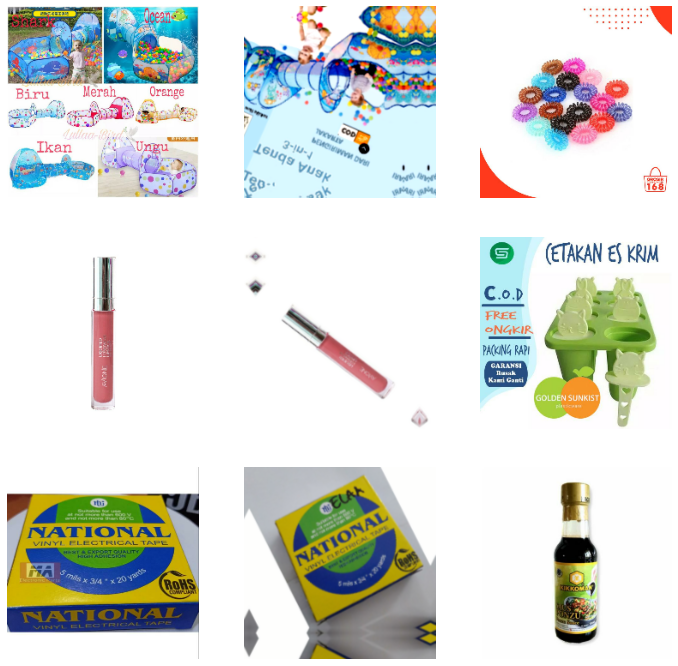

In [ ]:
#@title Visualize some triplets

ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for anchor_batch, positive_batch, negative_batch in train_ds.take(1):
    i = 0
    for anchor, positive, negative in zip(anchor_batch, positive_batch, negative_batch):
        plt.subplot(spec[ncols*i])
        plt.imshow(anchor)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 1])
        plt.imshow(positive)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 2])
        plt.imshow(negative)
        plt.axis('off')
        
        i += 1
        if i == nrows:
            break
plt.show()

In [ ]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

## Setup model

In [ ]:
#@title Define embedding model (Run only once)
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

output = layers.Flatten()(base_model.output)
output = layers.Dense(512, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)

embedding = Model(base_model.input, output, name='Embedding')


In [ ]:
embedding.summary()

In [ ]:
#@title Choose layer to freeze

layer_name = 'multiply_61' #@param {type: 'string'}

trainable = False
for layer in base_model.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable

class Distance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = layers.Input(name='anchor', shape=(224, 224, 3))
positive_input = layers.Input(name='positive', shape=(224, 224, 3))
negative_input = layers.Input(name='negative', shape=(224, 224, 3))

distances = Distance()(
    embedding(mobilenet_v3.preprocess_input(anchor_input)),
    embedding(mobilenet_v3.preprocess_input(positive_input)),
    embedding(mobilenet_v3.preprocess_input(negative_input))
)

siamese_base = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances
)

class SiameseNet(Model):
    """
    Siamese network with triplet loss:
        L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_base, margin=0.5):
        super(SiameseNet, self).__init__()
        self.siamese_base = siamese_base
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siamese_base(inputs)

    @tf.function
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_base(data)
        loss = tf.maximum(ap_distance + self.margin - an_distance, 0.0)
        return loss

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_base.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_base.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {'val_loss': self.loss_tracker.result()}

    @property
    def metrics(self):
        # list our metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]



In [ ]:
class SaveModelOnBatch(callbacks.Callback):
    def __init__(self, n, path, terminate_batch=None):
        super(SaveModelOnBatch, self).__init__()
        self.n = n
        self.path = path
        self.terminate_batch = terminate_batch

    def on_train_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.n == 0:
            print('Current loss:', logs.get('loss'))
            embedding.save(self.path + os.sep + 'embedding')
            print('embedding saved at', self.path + os.sep + 'embedding')
            # siamese_base.save(self.path + os.sep + 'siamese_base')
            # print('siamese_base saved at', self.path + os.sep + 'siamese_base')
        if batch == self.terminate_batch:
            self.model.stop_training = True
            return

In [ ]:
model = SiameseNet(siamese_base, 1.0)
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True))
history = model.fit(train_ds, 
          epochs=2, 
          validation_data=val_ds, 
          shuffle=True, 
          callbacks=[SaveModelOnBatch(200, '/content/drive/MyDrive/checkpoint'),
                    #  callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=1, verbose=1),
                    #  callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
                     ]
)

Epoch 1/2
  200/34388 [..............................] - ETA: 68:10:51 - loss: 0.9034Current loss: 0.9027803540229797
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  400/34388 [..............................] - ETA: 69:30:45 - loss: 0.8640Current loss: 0.8638365268707275
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  600/34388 [..............................] - ETA: 70:01:35 - loss: 0.8315Current loss: 0.8313974738121033
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  800/34388 [..............................] - ETA: 69:50:16 - loss: 0.8076Current loss: 0.8075528144836426
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1000/34388 [..............................] - ETA: 69:42:29 - loss: 0.7893Current loss: 0.7893808484077454
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1200/34388 [>.............................] - ETA: 69:29:54 - loss: 0.7693Current loss: 0.7691348791122437
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1400/34388 [>.............................] - ETA: 69:13:29 - loss: 0.7498Current loss: 0.7497460842132568
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1600/34388 [>.............................] - ETA: 68:56:01 - loss: 0.7347Current loss: 0.7345338463783264
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1800/34388 [>.............................] - ETA: 68:40:12 - loss: 0.7186Current loss: 0.7184807062149048
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2000/34388 [>.............................] - ETA: 68:18:45 - loss: 0.7041Current loss: 0.7040671706199646
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2088/34388 [>.............................] - ETA: 68:27:57 - loss: 0.6989

batch = 64 hội tụ nhanh hơn 32

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [ ]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding_0')

In [ ]:
%%time

anchor_paths = (str(train_img_dir) + os.sep + anchor_df['image']).to_list()
anchor_label_group = anchor_df.index.to_list()

anchor_embedding = embedding.predict(
    mobilenet_v3.preprocess_input(
        tf.data.Dataset.from_tensor_slices(anchor_paths).map(
            filepath_to_img, num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(buffer_size=512).batch(32)
    )
)

# anchor_embedding = tf.data.Dataset.from_tensor_slices(anchor_embedding)

CPU times: user 2min, sys: 6.68 s, total: 2min 6s
Wall time: 1min 19s


In [ ]:
# %%time

label_group_to_anchor_index = np.vectorize(lambda label_group: anchor_label_group.index(label_group))

val_predictions = tf.data.Dataset.from_tensor_slices(str(train_img_dir) + os.sep +  val_df['image'])

val_predictions = val_predictions.map(lambda filepath: tf.squeeze(embedding(tf.expand_dims(mobilenet_v3.preprocess_input(data_augmentation(filepath_to_img(filepath))), axis=0))))
val_predictions = val_predictions.prefetch(buffer_size=11004)

val_predictions = val_predictions.map(lambda embedding_vector: tf.map_fn(lambda x: 1/tf.reduce_sum(tf.square(x - embedding_vector)), anchor_embedding))

In [ ]:
label = label_group_to_anchor_index(val_df['label_group'])
pred = [p for p in val_predictions]

In [ ]:
val_accuracy = metrics.SparseCategoricalAccuracy()

for l, p in zip(label, pred):
    val_accuracy.update_state(l, p)  

val_accuracy.result()  

# hmmm

In [23]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.7 MB/s 


In [25]:
import tensorflow_addons as tfa


In [99]:
resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255)
     ]
)

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("vertical"),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath, label):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    img = tf.image.convert_image_dtype(img, tf.float32) # to [0, 1]
    img = tf.image.resize(img, (224, 224))

    

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + train_df['image'],
                                               label_encoder.transform(train_df['label_group'])))
val_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + val_df['image'],
                                             label_encoder.transform(val_df['label_group'])))

def configure_dataset(ds, mode):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    if mode == 'training':
        ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.map(lambda filepath, label_group: (filepath_to_img(filepath), label_group), 
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.prefetch(buffer_size=512)


    # if mode == 'validation':        ###############################
    # ds = ds.cache()

    if mode == 'training':
        ds = ds.map(lambda img, label_group: (data_augmentation(img), label_group), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.batch(128)
    
    return ds

train_ds = configure_dataset(train_ds, mode='training')
val_ds = configure_dataset(val_ds, mode='validation')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


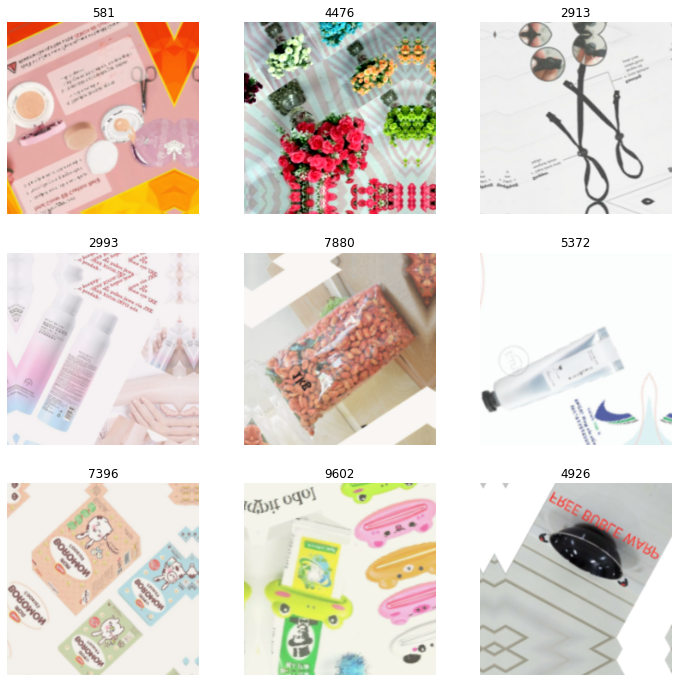

In [73]:
ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for img_batch, label_batch in train_ds.take(1):
    i = 0
    for img, label in zip(img_batch, label_batch):
        plt.subplot(spec[i])
        plt.imshow(img)
        plt.title(label.numpy())
        plt.axis('off')

        i += 1
        if i == nrows * ncols:
            break
plt.show()

In [110]:
#@title Define embedding model (Run only once)
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

output = layers.Flatten()(base_model.output)
# output = layers.Dense(512, activation='relu')(output)
# output = layers.BatchNormalization()(output)
# output = layers.Dense(256, activation='relu')(output)
# output = layers.BatchNormalization()(output)
output = layers.Dense(256)(output)
# output = layers.BatchNormalization()(output)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)


embedding = Model(base_model.input, output, name='Embedding')


In [ ]:
embedding.summary()

In [103]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

In [90]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 56, 56, 32)       

In [20]:
#@title Choose layer to freeze

layer_name = 'multiply_37' #@param {type: 'string'}

trainable = False
for layer in base_model.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable




In [113]:
embedding.compile(
    optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=['accuracy'])

history = embedding.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds)

Epoch 1/5
225/225 [==============================] - 803s 4s/step - loss: nan - accuracy: 1.0440e-04 - val_loss: nan - val_accuracy: 9.0876e-05
Epoch 2/5
176/225 [======================>.......] - ETA: 2:38 - loss: nan - accuracy: 8.8778e-05

KeyboardInterrupt: ignored

In [61]:
for img, label in train_ds.take(1):
    pred = embedding.predict(img)
    loss = tfa.losses.TripletSemiHardLoss()(label, pred)
    print(loss)

tf.Tensor(nan, shape=(), dtype=float32)


In [66]:
from sklearn.preprocessing import LabelEncoder

In [67]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label_group'])

LabelEncoder()

In [69]:
a = label_encoder.transform(train_df['label_group'])

In [71]:
np.max(a)

11003